In [1]:
#%matplotlib widget

In [5]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from dPCA import dPCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
#import pca_tools
seed=2024

### Define functions

In [6]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [7]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [8]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [1]:
def get_fr_samples(sp,sample_id,start,end,samples,rng,n_trials,seed):
    # parameters
    #rng = np.random.default_rng(seed=seed)
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>1
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = sp#firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        trials_list = rng.choice(sample_fr.shape[0], size=n_trials, replace=False)
        fr_samples.append(sample_fr[trials_list])
    return np.array(fr_samples)

In [10]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<50:
        return {'fr':None}
    #non_zero_mask = np.sum(sp_sample_on[:,idx_start:idx_end],axis=1)>0
    sample_id = neu_data.sample_id[mask]#[non_zero_mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51],rng=rng)
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [11]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    mask_match_neu = np.logical_or(mask_match,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)

    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [12]:
def get_fr_nksmt(path,time_before,start,end,end_test,n_test,rng,n_trials,seed):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_noneu = neu_data.sample_id[mask_test1]!=0
    mask_match_nonneu = np.logical_and(mask_match,mask_noneu)
    mask_nonmatch_nonneu = np.logical_and(~mask_match,mask_noneu)
    if np.sum(mask_noneu)<20:
        return {'fr':None}
 
    sp=np.concatenate((sp_sample_on[mask_match_nonneu,:time_before+450+200],sp_test1_on[mask_match_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_match_nonneu]
    fr_samples_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)

    sp=np.concatenate((sp_sample_on[mask_nonmatch_nonneu,:time_before+450+200],sp_test1_on[mask_nonmatch_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_nonmatch_nonneu]
    fr_samples_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    
    if fr_samples_match is None:
        return {'fr':None}
    if fr_samples_nonmatch is None:
        return {'fr':None}
    fr_samples = np.array([fr_samples_match,fr_samples_nonmatch])
    return {'fr':fr_samples}

In [13]:
def select_trials(neu_data,select_block,code,time_before,error_type=0):
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= error_type,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= error_type,
    )
    if np.any(mask_sample != mask_test1):
        return "error"
    return sp_sample_on,sp_test1_on,mask_sample,mask_test1

In [14]:
# will not have enough error trials
def get_fr_nksmdt(path,time_before,start,end,end_test,n_test,rng,n_trials,seed):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=0)
    
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_noneu = neu_data.sample_id[mask_test1]!=0
    mask_match_nonneu = np.logical_and(mask_match,mask_noneu)
    mask_nonmatch_nonneu = np.logical_and(~mask_match,mask_noneu)
    if np.sum(mask_noneu)<20:
        return {'fr':None}
    
    # Correct desition Match
    sp=np.concatenate((sp_sample_on[mask_match_nonneu,:time_before+450+200],sp_test1_on[mask_match_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_match_nonneu]
    fr_samples_correct_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    # Correct desition Non-Match
    sp=np.concatenate((sp_sample_on[mask_nonmatch_nonneu,:time_before+450+200],sp_test1_on[mask_nonmatch_nonneu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_nonmatch_nonneu]
    fr_samples_correct_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    # Incorrect desition Match
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=8)
    sp=np.concatenate((sp_sample_on[:,:time_before+450+200],sp_test1_on[:,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1]
    fr_samples_incorrect_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
    # Incorrect desition Match
    sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,code,time_before,error_type=6)
    sp=np.concatenate((sp_sample_on[:,:time_before+450+200],sp_test1_on[:,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1]
    fr_samples_incorrect_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)

    if fr_samples_correct_match is None:
        return {'fr':None}
    if fr_samples_correct_nonmatch is None:
        return {'fr':None}
    if fr_samples_incorrect_match is None:
        return {'fr':None}
    if fr_samples_incorrect_nonmatch is None:
        return {'fr':None}
    fr_samples = np.array([[fr_samples_correct_match,fr_samples_correct_nonmatch],[fr_samples_incorrect_match,fr_samples_incorrect_nonmatch]])
    return {'fr':fr_samples}

In [15]:
def get_fr_nksmrt(path,time_before,start,end,end_test,n_test,rng,n_trials,seed): 
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    idx_start = time_before + start 
    idx_end = time_before+end
    pos_fr=[]
    for pos in [1,-1]:    
        # Select trials aligned to sample onset
        sp_sample_on,sp_test1_on,mask_sample,mask_test1 = select_trials(neu_data,select_block,pos,time_before,error_type=0) 
        
        mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
        mask_noneu = neu_data.sample_id[mask_test1]!=0
        mask_match_nonneu = np.logical_and(mask_match,mask_noneu)
        mask_nonmatch_nonneu = np.logical_and(~mask_match,mask_noneu)
        if np.sum(mask_noneu)<20:
            return {'fr':None}
    
        sp=np.concatenate((sp_sample_on[mask_match_nonneu,:time_before+450+200],sp_test1_on[mask_match_nonneu,:end_test+400]),axis=1)
        sample_id = neu_data.sample_id[mask_test1][mask_match_nonneu]
        fr_samples_match = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)

        sp=np.concatenate((sp_sample_on[mask_nonmatch_nonneu,:time_before+450+200],sp_test1_on[mask_nonmatch_nonneu,:end_test+400]),axis=1)
        sample_id = neu_data.sample_id[mask_test1][mask_nonmatch_nonneu]
        fr_samples_nonmatch = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[11,15,55,51],rng=rng,n_trials=n_trials,seed=seed)
        
        if fr_samples_match is None:
            return {'fr':None}
        if fr_samples_nonmatch is None:
            return {'fr':None}
        pos_fr.append(np.array([fr_samples_match,fr_samples_nonmatch]))
    fr_samples = np.array(pos_fr)
    return {'fr':fr_samples}

### Read data

In [16]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [21]:
area='pfc'
neu_path = basepath+'session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [22]:
# Load data
save_fig=False
n_test=1
time_before=500
start=-400
end_test = n_test*450+200
end=450+200+200+end_test
n_trials=10
idx_start = time_before + start 
idx_end = time_before+end
T=end-start
T

1900

In [35]:
basepath = (
    "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/"
    + "LIP/nksmt"
)
path = basepath + "/fr_dpca_lip_trials_" + str(n_trials) + "_nksmt.hs"
X_fr_raw_lip = from_python_hdf5(path)[0]["pp"]
fold_size = X_fr_raw_lip.shape[1]

basepath = (
    "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/"
    + area.upper()
    + "/nksmt"
)
path = basepath + "/fr_dpca_" + area + "_trials_" + str(n_trials) + "_nksmt.hs"
X_fr_raw_all = from_python_hdf5(path)[0]["pp"]


k_folds = int(np.floor(X_fr_raw_all.shape[1] / fold_size))
rng = np.random.default_rng(seed=seed)
neurons_folds = rng.choice(
    X_fr_raw_all.shape[1], size=k_folds * fold_size, replace=False
)
neurons_folds1 = neurons_folds.reshape(k_folds, -1)
neurons_folds = neurons_folds1.copy()
if k_folds!=1:
    rng.shuffle(neurons_folds1,axis=0)
neurons_folds = np.concatenate((neurons_folds,neurons_folds1),axis=0)

In [36]:
neurons_folds=neurons_folds1.copy()
if k_folds!=1:
    rng.shuffle(neurons_folds1,axis=0)
neurons_folds = np.concatenate((neurons_folds,neurons_folds1),axis=0)

In [37]:
neurons_folds.shape

(14, 161)

In [16]:
rng = np.random.default_rng(seed=seed)
seed_list = rng.choice(3000, size=len(path_list), replace=False)
data = Parallel(n_jobs = -1)(delayed(get_fr_nksmt)(path_list[i],time_before,start,end,end_test,n_test,rng,n_trials,seed_list[i]) for i in tqdm(np.arange(len(path_list))))

100%|██████████| 2023/2023 [47:36<00:00,  1.41s/it]


In [44]:
X_all = []
N = 0
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        N+=1
        X_all.append(fr)
#to_python_hdf5(dat=X_full, save_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'_win50_test'+str(n_test)+'_dpca.h5')

In [45]:
np.array(X_all).shape

(1209, 2, 4, 10, 1900)

In [46]:
X_fr_raw = np.array(X_all)#.reshape(-1,1050)
X_fr_raw =np.transpose(X_fr_raw,(3,0,2,1,4))#np.transpose(X_fr_raw,(4,0,1,2,3,5))#
X_fr_raw.shape

(10, 1209, 4, 2, 1900)

In [47]:
basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/dpca/data/'+area+'/'
path = basepath + 'fr_dpca_'+ area +'_trials_' + str(n_trials)+'_fr_filt1' + '_nksmt.hs'
if not os.path.isfile(path):
    to_python_hdf5(dat=[{'pp':X_fr_raw}], save_path=path)

In [48]:
X_fr_raw = from_python_hdf5(path)[0]['pp']#
X_fr_raw.shape

(10, 313, 4, 2, 1900)

In [49]:
X_fr = firing_rate.convolve_signal(arr=X_fr_raw,fs = 1000,w_size=0.1,w_std=0.015,axis=-1)[:,:,:,:,200:1500+200]
X_fr.shape

(10, 313, 4, 2, 1500)

In [50]:
N=X_fr.shape[1]
# trial-average data
X = np.mean(X_fr,0)
# center data
#X -= np.mean(X.reshape((N,-1)),1)[:,None,None]
print(X.shape)

(313, 4, 2, 1500)


In [51]:
dpca = dPCA.dPCA(labels='smt',join= {'st' : ['s','st'],'mt' : ['m','mt'],'smt' : ['sm','smt']},regularizer=0,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
#dpca = dPCA.dPCA(labels='rmst',join= {'rt' : ['r','rt'],'mt' : ['m','mt'],'st' : ['s','st'],'rmt' : ['rm','rmt'],'rst' : ['rs','rst'],'mst' : ['ms','mst'],'rmst' : ['rms','rmst']},regularizer=0,n_components=100,n_iter=5)#X_fr.shape[1] ,'rt' : ['r','rt']
dpca.protect = ['t']
#dpca.n_trials = 3
comp = dpca.fit_transform(X,X_fr)

In [52]:
list(comp.keys())

['t', 'st', 'mt', 'smt']

In [53]:
variances = dpca.get_variances(X)

In [54]:
marg_var_t = variances['marg_var']['t']
marg_var_st = variances['marg_var']['st']
marg_var_mt = variances['marg_var']['mt']
#marg_var_sm = variances['marg_var']['sm']
marg_var_smt = variances['marg_var']['smt']

In [55]:
samples={
    "o1_c1": 0,
    "o1_c5": 1,
    "o5_c5": 2,
    "o5_c1": 3,
}

In [56]:
save_fig=False

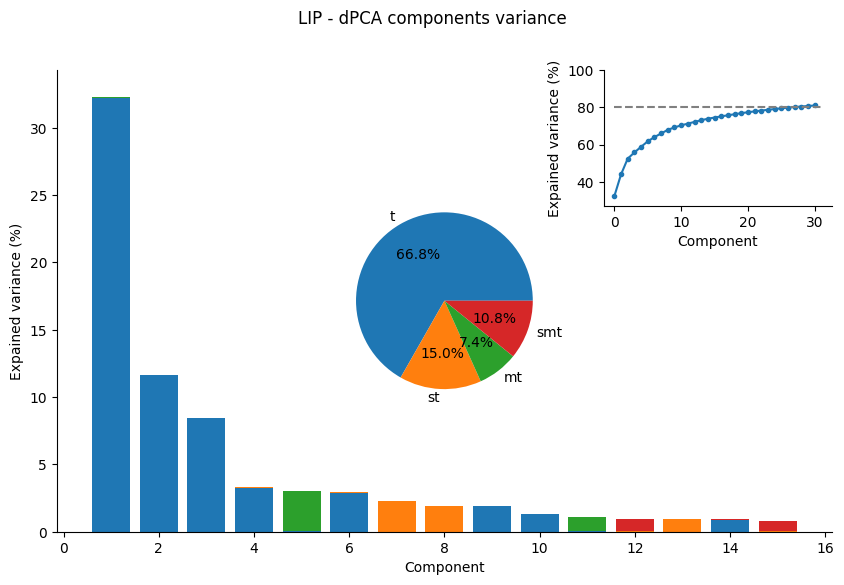

In [57]:
n_comp=15
t_var = np.array(marg_var_t[:n_comp])
st_var = np.array(marg_var_st[:n_comp])
mt_var = np.array(marg_var_mt[:n_comp])
#sm_var = np.array(marg_var_sm[:n_comp])
smt_var = np.array(marg_var_smt[:n_comp])

f,ax = plt.subplots(figsize=(10,6))
#ax.bar(range(n_comp),s_var, label='s')
ax.bar(np.arange(n_comp)+1,t_var, label='t')
ax.bar(np.arange(n_comp)+1,st_var, bottom= t_var, label='st')
ax.bar(np.arange(n_comp)+1,mt_var, bottom= (t_var+st_var), label='mt')
#ax.bar(np.arange(n_comp)+1,sm_var, bottom= (t_var+st_var+mt_var), label='sm')
ax.bar(np.arange(n_comp)+1,smt_var, bottom= (t_var+st_var+mt_var), label='smt')#+sm_var
ax.set(xlabel='Component', ylabel='Expained variance (%)')
#ax.legend()
ax.set_ylim(0,(t_var+st_var+mt_var+smt_var)[0]+2)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# f,ax = plt.subplots(figsize=(3,3))
ax2 = plt.subplot2grid((4, 4), (1, 1),2,2)
_=ax2.pie([variances['total_marg_var']['t'],variances['total_marg_var']['st'],variances['total_marg_var']['mt'],variances['total_marg_var']['smt']],labels=['t','st','mt','smt'],autopct='%1.1f%%')
ax3 = plt.subplot2grid((3, 3), (0, 2))
if np.any(variances['cumulative_var'][:n_comp-4]>80):
    i_comp = n_comp
elif np.any(variances['cumulative_var']>80):
    i_comp = np.where(variances['cumulative_var']>80)[0][0] +4
else:
    i_comp = len(variances['cumulative_var'])

ax3.plot(variances['cumulative_var'][:i_comp],'.-')
ax3.hlines(80,0,i_comp,colors='grey',linestyles='--')
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.set_ylim(np.min(variances['cumulative_var'][:i_comp])-5,100)
ax3.set(xlabel='Component', ylabel='Expained variance (%)')
f.suptitle('%s - dPCA components variance'%(area.upper()))
if save_fig:
    path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' + 'variance.jpg'
    f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)

In [58]:
comp_plot = 3

X_full = np.mean(X_fr,0)
X = X_full.reshape((N,-1))
X_cen = X- np.mean(X,1)[:,None]

Z_full = X_cen.T@dpca.D_sorted
which_marg=variances['which_marg']
components =np.concatenate([np.where(which_marg==i)[0][:comp_plot] for i in list(comp.keys())])
Z= Z_full.T[components].reshape(np.concatenate((components.shape,X_full.shape[1:])))
Z.shape

(12, 4, 2, 1500)

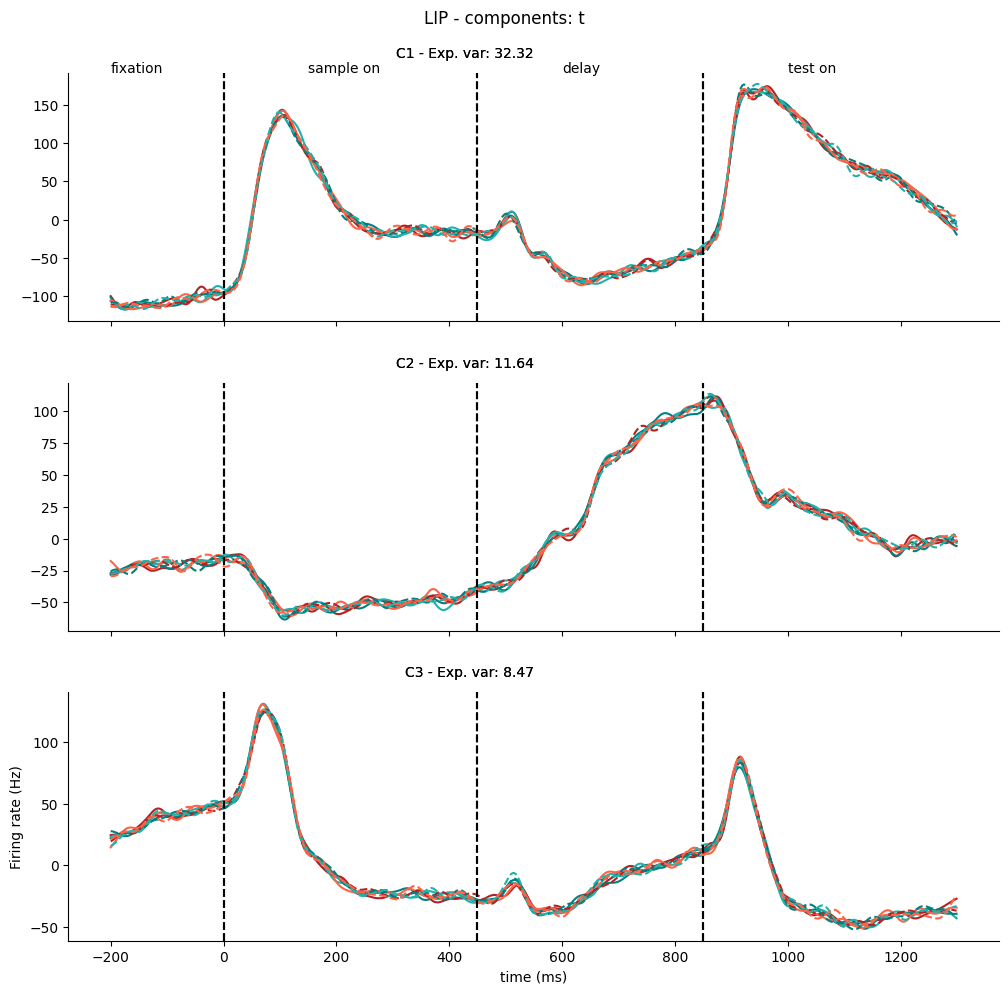

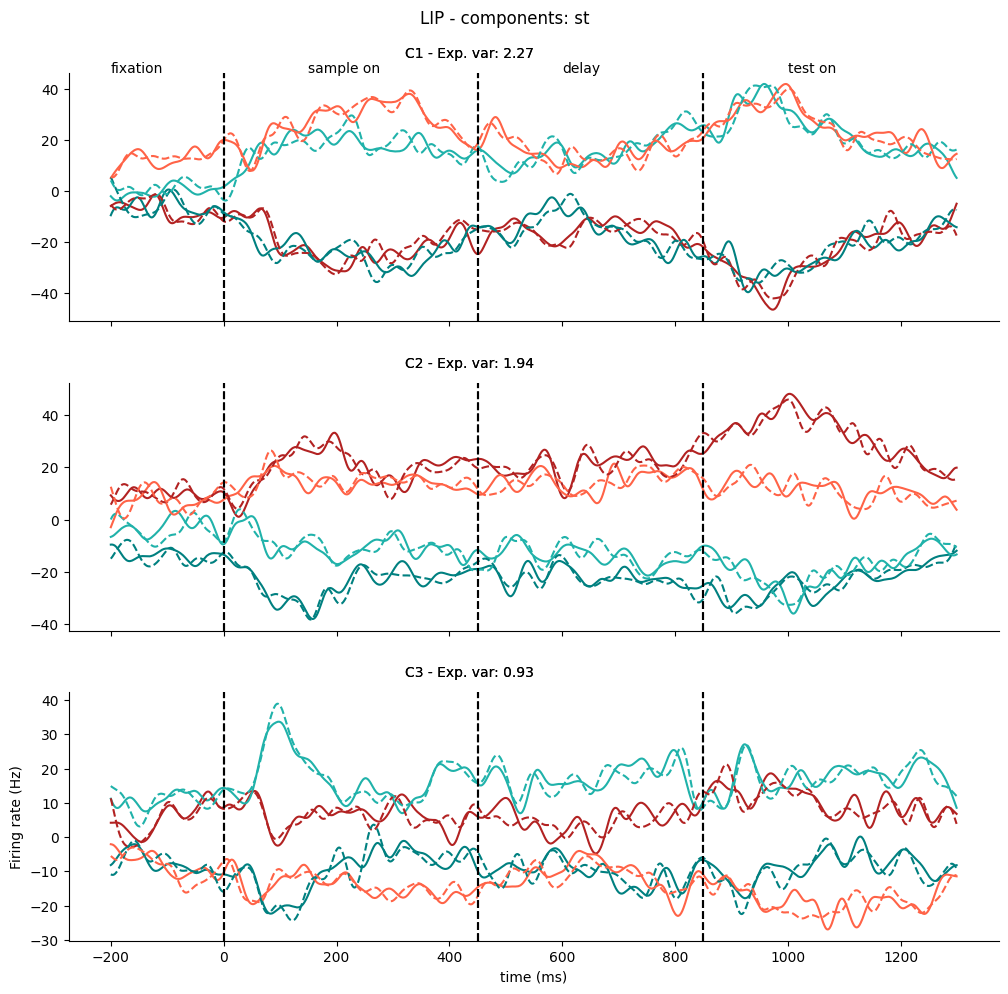

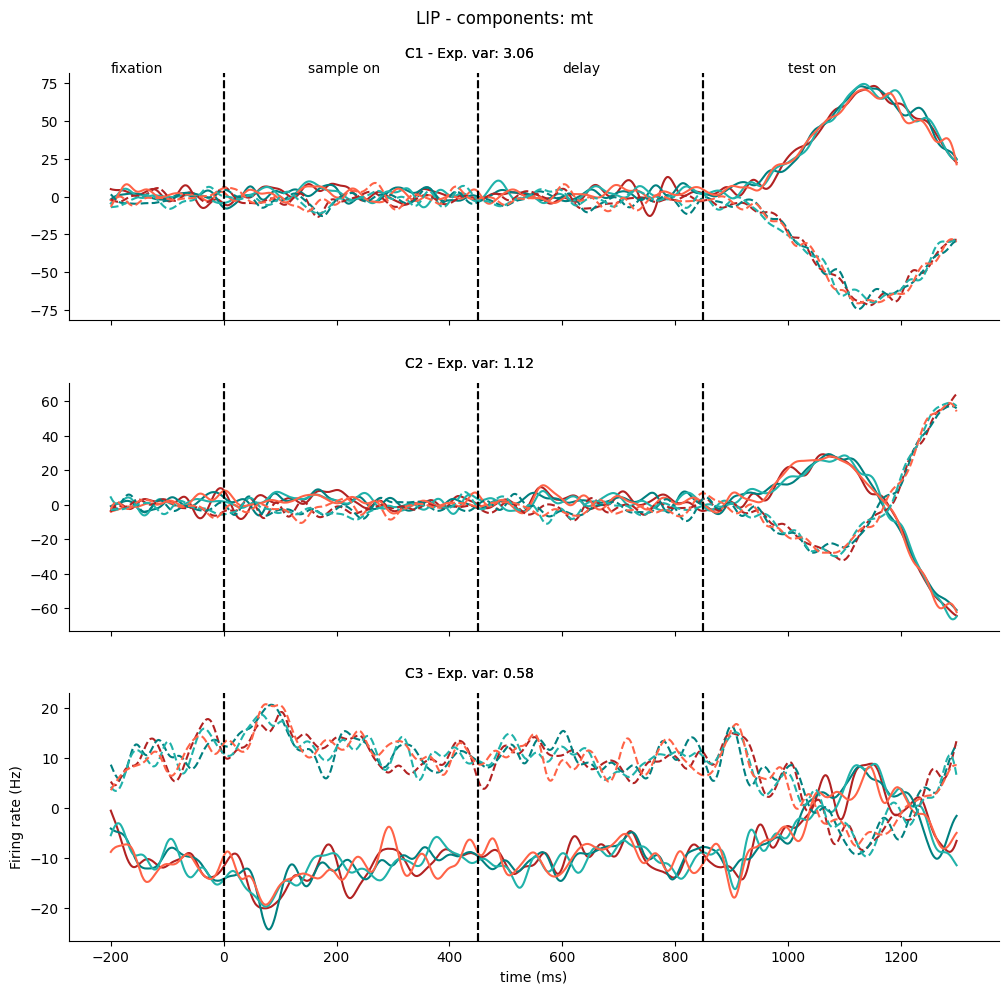

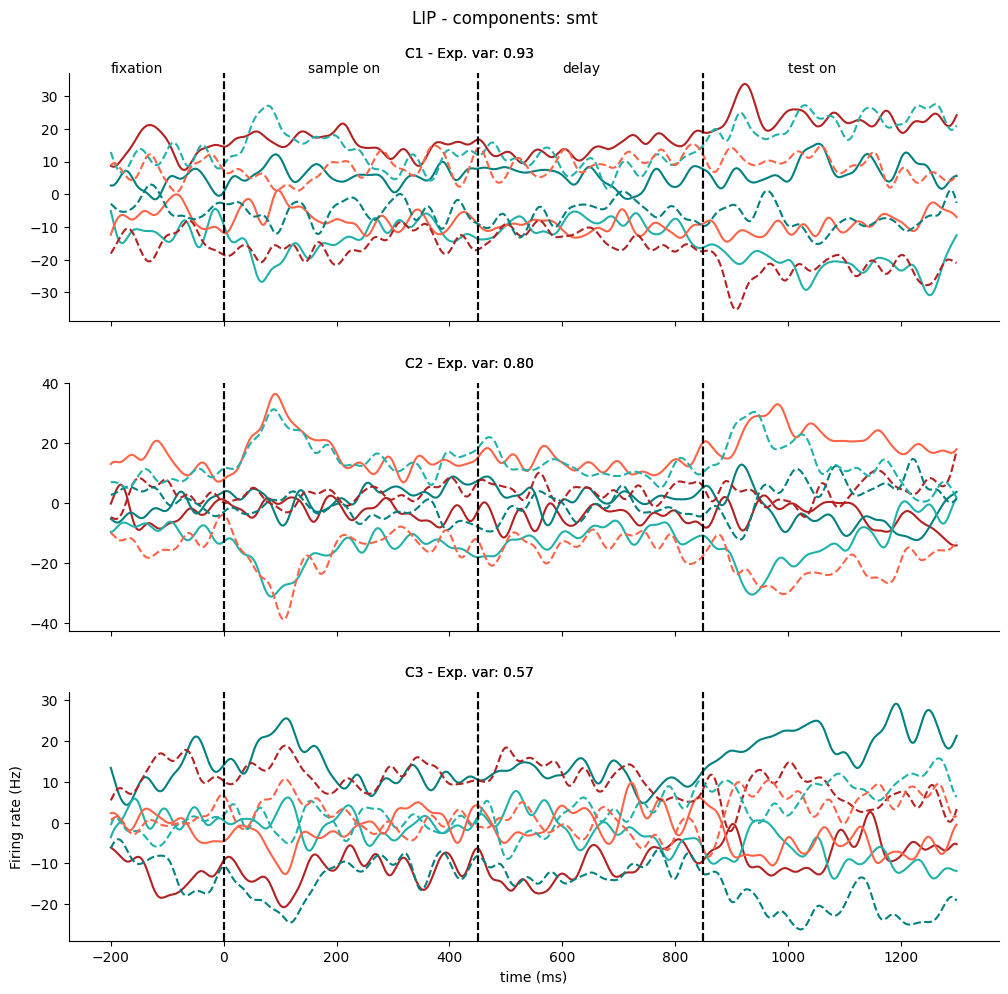

In [59]:
time = np.arange(T-400)-200
n_plots,i_plot=0,0#
for i in range(Z.shape[0]):
    i_comp = which_marg[components[i]]
    if i_plot!=0 and i_plot < comp_plot:
        ax=ax_all[i_plot]
        i_plot+=1
    else:    
        f,ax_all=plt.subplots(3,1,figsize=(10,10),sharex=True)
        ax=ax_all[0]
        i_plot =1
    for i_m in range(2):
        lstyle = '-' if i_m == 0 else '--'
        for s in samples.keys():
            ax.plot(time,Z[i][samples[s]][i_m],color=task_constants.PALETTE_B1[s],linestyle=lstyle)
        max_v = np.max(Z[i][samples[s]])
        min_v = np.min(Z[i][samples[s]])
        ax.axvline(0,color='k',linestyle='--')
        ax.axvline(450,color='k',linestyle='--')
        ax.axvline(850,color='k',linestyle='--')
        ax.text(0.5,1.05,'C%d - Exp. var: %.2f'%(i_plot,variances['component_var'][components][i]),horizontalalignment='right',verticalalignment='bottom',transform=ax.transAxes)
        ax.set_title(' ',fontsize=40)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
    if i_plot == 1:
        ax.text(-200, ax.get_ylim()[1], 'fixation')
        ax.text(150, ax.get_ylim()[1], 'sample on')
        ax.text(600, ax.get_ylim()[1], 'delay')
        ax.text(1000, ax.get_ylim()[1], 'test on')
    if i_plot == 3:
        ax.set(xlabel='time (ms)', ylabel='Firing rate (Hz)')
    f.suptitle('%s - components: %s'%(area.upper(),i_comp))
    f.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    if save_fig:
        path=basepath + '/fr_dpca_'+ area +'_trials_' + str(n_trials) + '_nksmt_' +i_comp+ '_components.jpg'
        f.savefig(path,format='jpg',bbox_inches="tight", transparent=False)